In [0]:
!pip install xgboost

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
import os
DIRECTORY = "dbfs:/FileStore/tables/data/emrcode"
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder, ChiSqSelector, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import  Vectors
from pyspark.sql import DataFrame
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
import pandas as pd
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.regression import DecisionTreeRegressor
import time

Priniting The Schema of the data

In [0]:
spark = SparkSession.builder.getOrCreate()
airbnbdata = spark.read.csv(
                path=os.path.join(DIRECTORY, "Finaldataairbnb2.csv"),
                sep=",",
                inferSchema=True,
                header=True
)
 
print(airbnbdata.count(), len(airbnbdata.columns))

airbnbdata.printSchema()

400020 20
root
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_listings_count: string (nullable = true)
 |-- host_total_listings_count: string (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- street: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: string (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- guests_included: double (nullable = true)



Data Summary

In [0]:
for x in airbnbdata.columns:
    airbnbdata.select(x).summary().show()
    break

+-------+------------------+
|summary|host_response_time|
+-------+------------------+
|  count|            400020|
|   mean|       2.2775045E7|
| stddev|               0.0|
|    min|         20720012"|
|    25%|       2.2775045E7|
|    50%|       2.2775045E7|
|    75%|       2.2775045E7|
|    max|    within an hour|
+-------+------------------+



Standerdizing Data

In [0]:

airbnbdata = airbnbdata.withColumn("price", F.regexp_replace("price", "[^0-9.]", "").cast("double"))
airbnbdata = airbnbdata.withColumn("host_response_rate", F.regexp_replace("host_response_rate", "[^0-9.]", "").cast("double"))
airbnbdata = airbnbdata.withColumn("host_listings_count",F.regexp_replace("host_listings_count", "[^0-9.]", "").cast("double"))
airbnbdata = airbnbdata.withColumn("host_total_listings_count",F.regexp_replace("host_total_listings_count", "[^0-9.]", "").cast("double"))
airbnbdata = airbnbdata.withColumn("accommodates",airbnbdata.accommodates.cast('double'))

In [0]:
airbnbdata.printSchema()


root
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: double (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_listings_count: double (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- street: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- guests_included: double (nullable = true)



In [0]:
airbnbdata[['host_response_time', 'bed_type', 'room_type','price','host_response_rate']].show()

+------------------+--------+---------------+------+------------------+
|host_response_time|bed_type|      room_type| price|host_response_rate|
+------------------+--------+---------------+------+------------------+
|    within an hour|Real Bed|Entire home/apt| 307.0|             100.0|
|within a few hours|Real Bed|Entire home/apt| 159.0|             100.0|
|    within an hour|Real Bed|Entire home/apt| 253.0|             100.0|
|    within an hour|Real Bed|Entire home/apt| 350.0|             100.0|
|    within an hour|Real Bed|Entire home/apt| 221.0|             100.0|
|    within an hour|Real Bed|Entire home/apt|3392.0|              97.0|
|within a few hours|Real Bed|   Private room| 120.0|             100.0|
|    within an hour|Real Bed|Entire home/apt| 556.0|             100.0|
|    within an hour|Real Bed|Entire home/apt| 175.0|             100.0|
|    within an hour|Real Bed|Entire home/apt| 882.0|              97.0|
|within a few hours|Real Bed|Entire home/apt|2409.0|            

Data Exploratory Analysis

Out[65]: <seaborn.axisgrid.PairGrid at 0x7f8a58a6ce80>

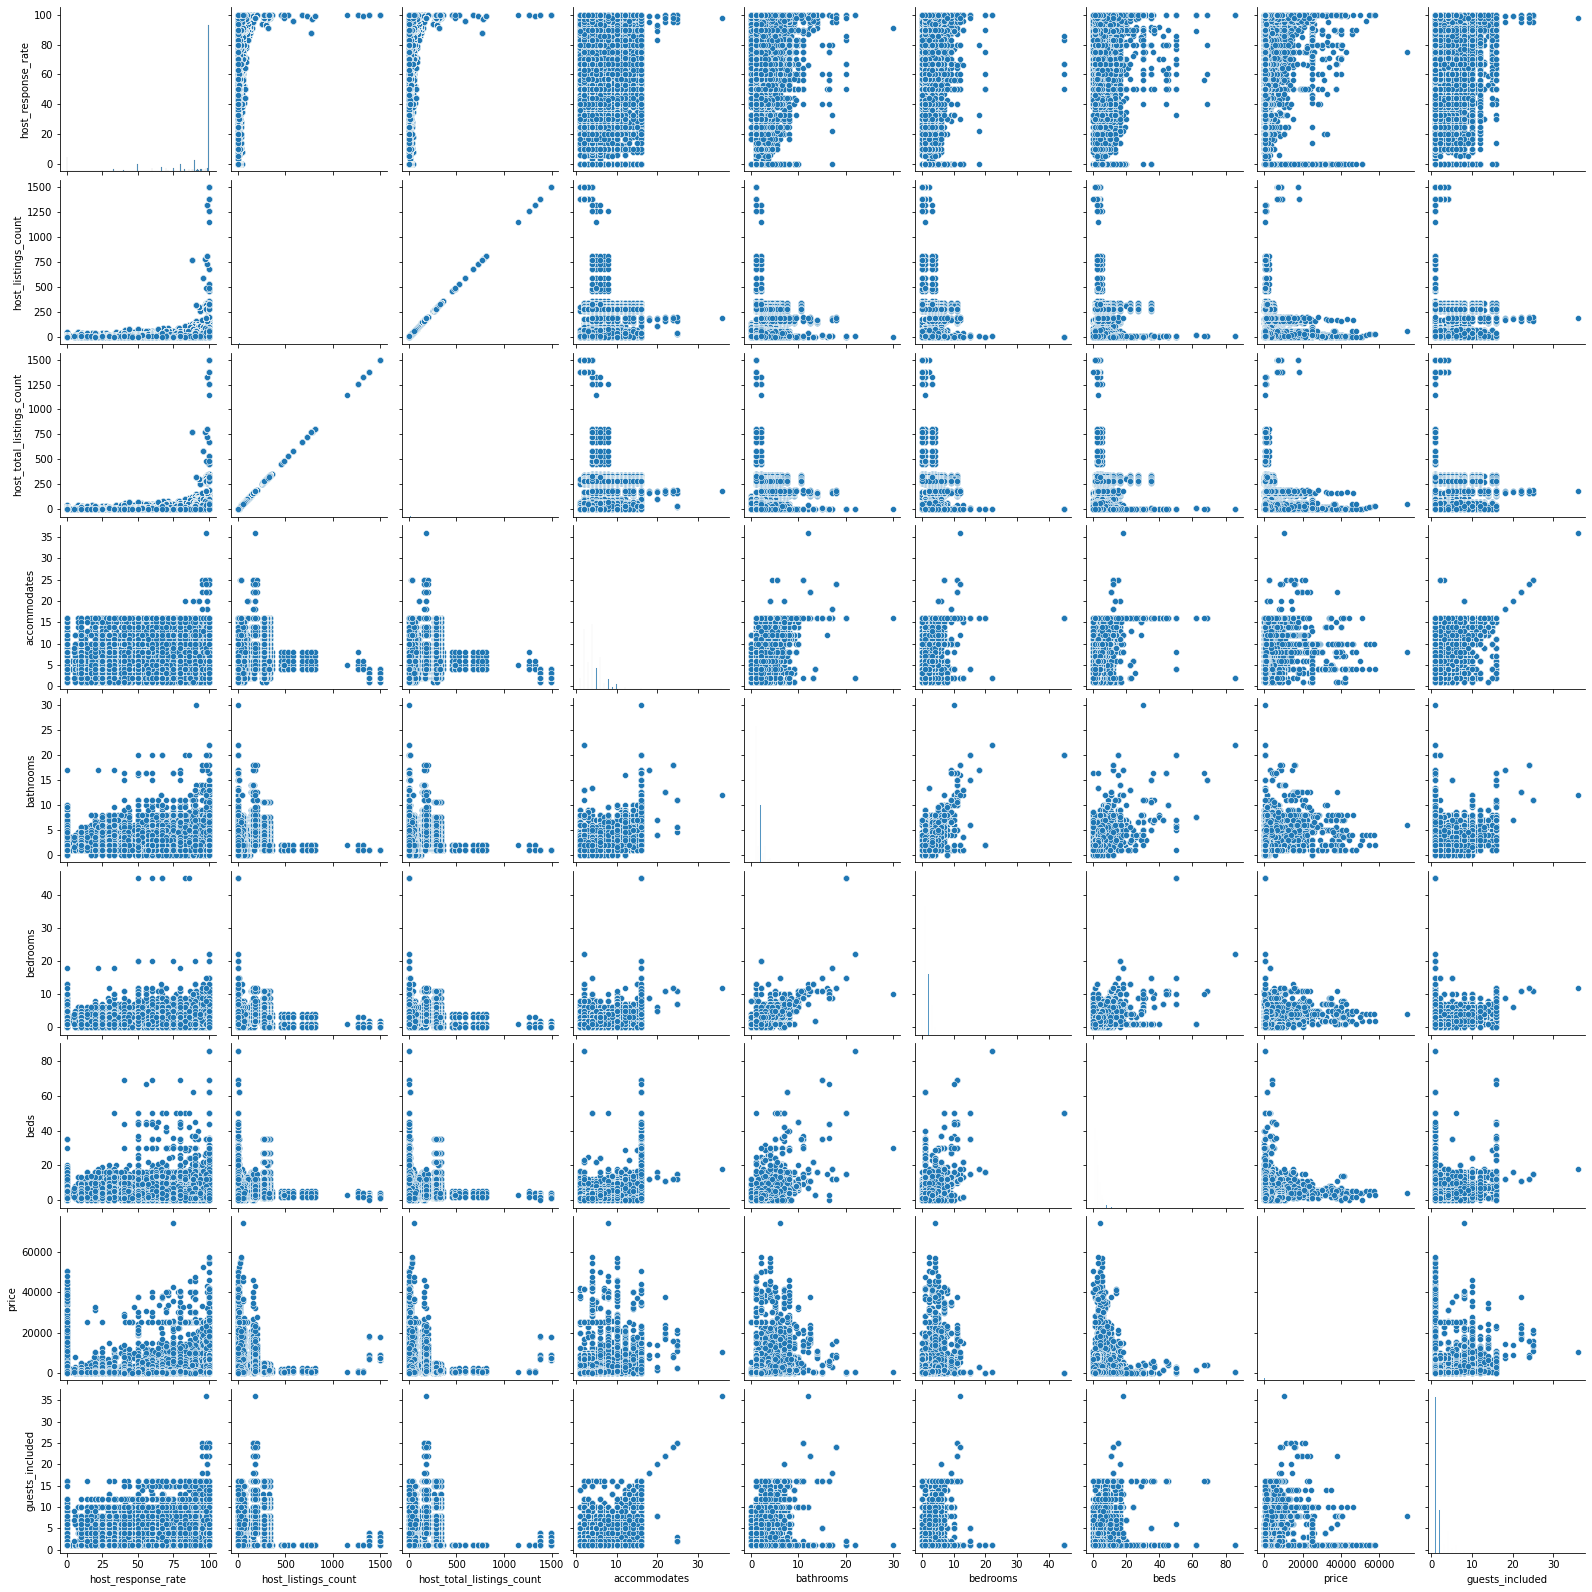

In [0]:
# convert PySpark DataFrame to Pandas DataFrame
pandas_df = airbnbdata.toPandas()

# create a pairplot using seaborn
sns.pairplot(pandas_df)

Out[66]: Text(0.5, 1.0, 'Room Type vs Price')

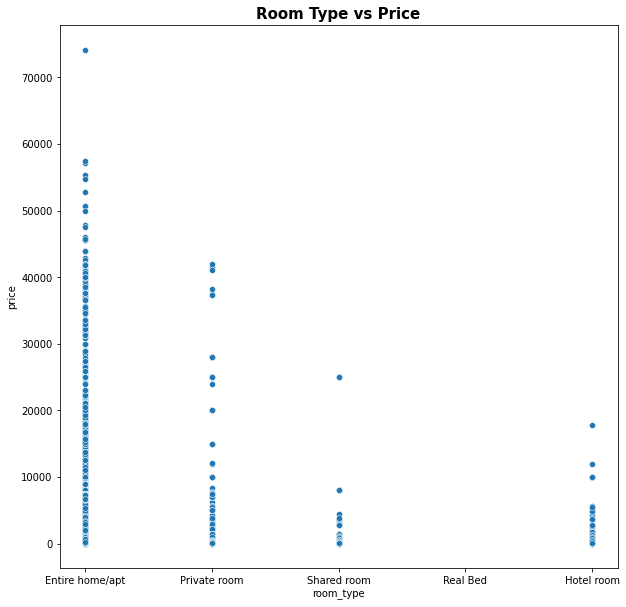

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="room_type", y="price", data=airbnbdata.toPandas())
plt.title("Room Type vs Price",size=15, weight='bold')

Out[67]: Text(0.5, 1.0, 'Bed Type vs Price')

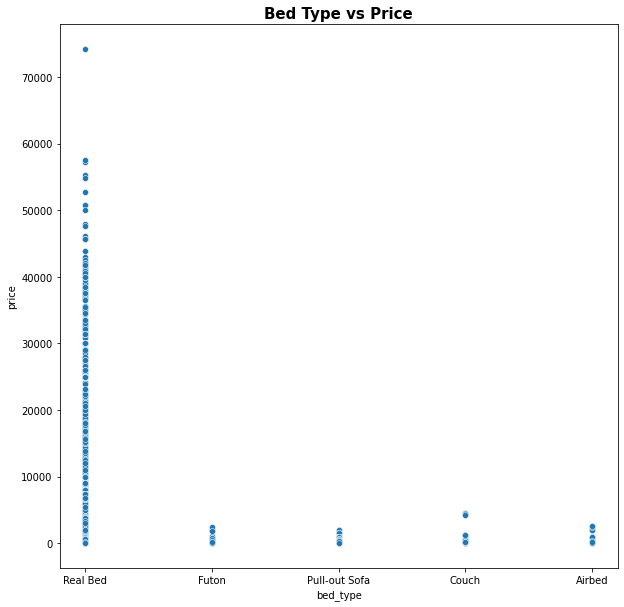

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="bed_type", y="price", data=airbnbdata.toPandas())
plt.title("Bed Type vs Price",size=15, weight='bold')

Out[68]: Text(0.5, 1.0, 'host has profile pic vs price')

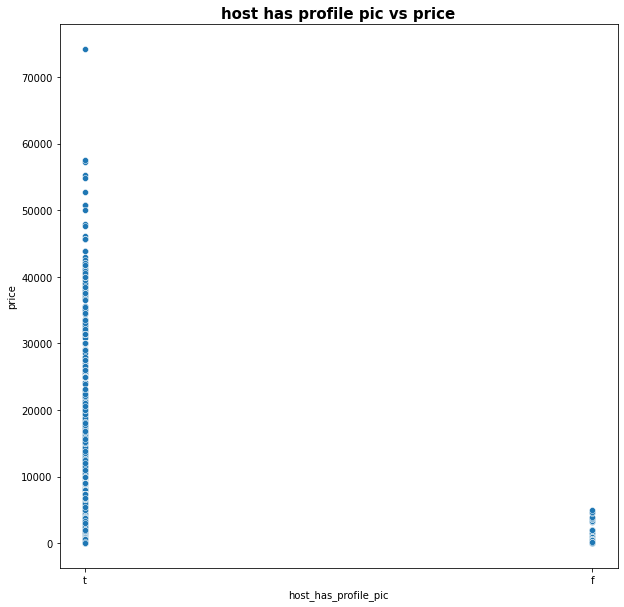

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="host_has_profile_pic", y="price", data=airbnbdata[['host_has_profile_pic','price']].toPandas())
plt.title("host has profile pic vs price",size=15, weight='bold')

Price Distribution Plot

/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Out[69]: Text(0.5, 1.0, 'Price Distribution Plot')

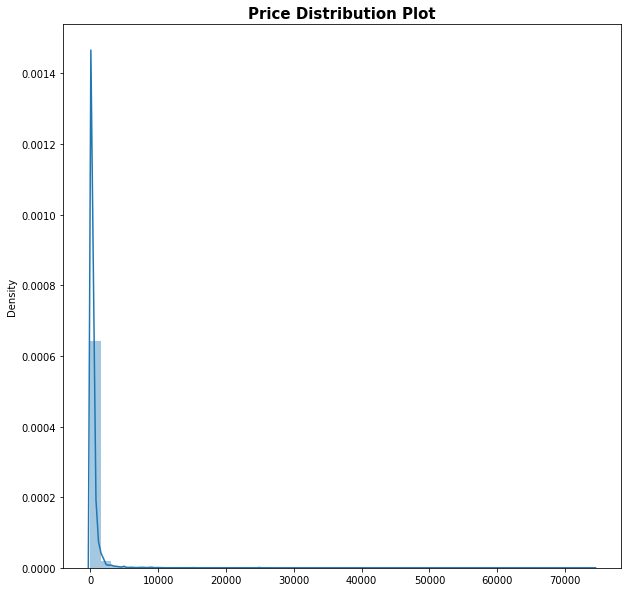

In [0]:
plt.figure(figsize=(10,10))
sns.distplot(airbnbdata.select("price").toPandas())
plt.title("Price Distribution Plot",size=15, weight='bold')

The above distribution graph shows that there is a right-skewed distribution on price. This means there is a positive skewness. Log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis

Since division by zero is a problem, log+1 transformation would be better.

In [0]:
airbnbdata = airbnbdata.withColumn("log_price", F.log("price"))

In [0]:
airbnbdata[['log_price']].show()

+------------------+
|         log_price|
+------------------+
| 5.726847747587197|
|5.0689042022202315|
|  5.53338948872752|
| 5.857933154483459|
|5.3981627015177525|
| 8.129174996911793|
| 4.787491742782046|
| 6.320768294250582|
|5.1647859739235145|
| 6.782192056006791|
| 7.786967002614872|
| 4.969813299576001|
| 6.878326468291325|
| 6.675823221634848|
| 7.499423290592229|
| 4.727387818712341|
|  5.14166355650266|
| 5.857933154483459|
| 5.673323267171493|
| 4.787491742782046|
+------------------+
only showing top 20 rows



/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Out[72]: Text(0.5, 1.0, 'Log-Price Distribution Plot')

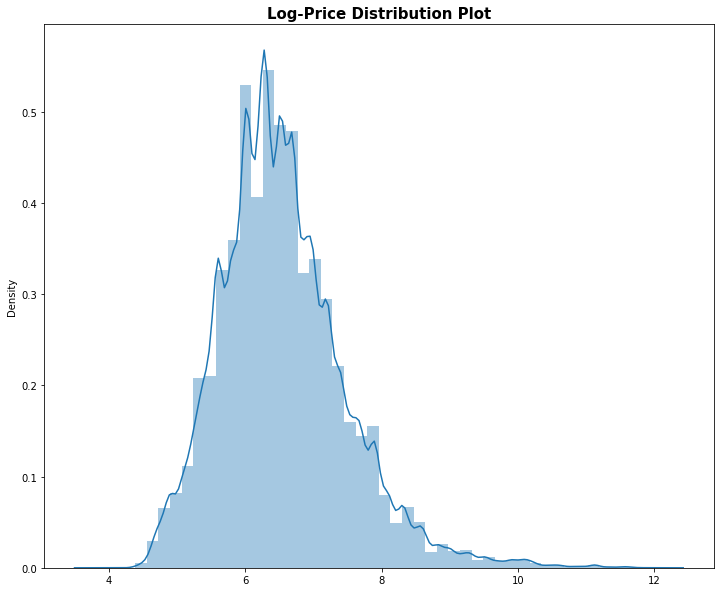

In [0]:
plt.figure(figsize=(12,10))
sns.distplot(airbnbdata.select("log_price").toPandas()+1)
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

In below graph, the good fit indicates that normality is a reasonable approximation.

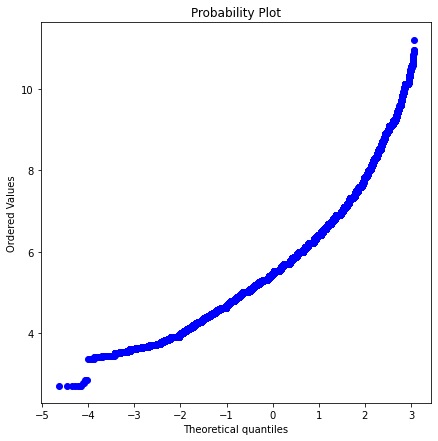

In [0]:
plt.figure(figsize=(7,7))
log_price = airbnbdata.select("log_price").toPandas()["log_price"]
stats.probplot(log_price, plot=sns.mpl.pyplot)
plt.show()

A correlation table will be created and the Pearson method will be used.

Out[74]: Text(0.5, 1.0, 'Correlation Matrix')

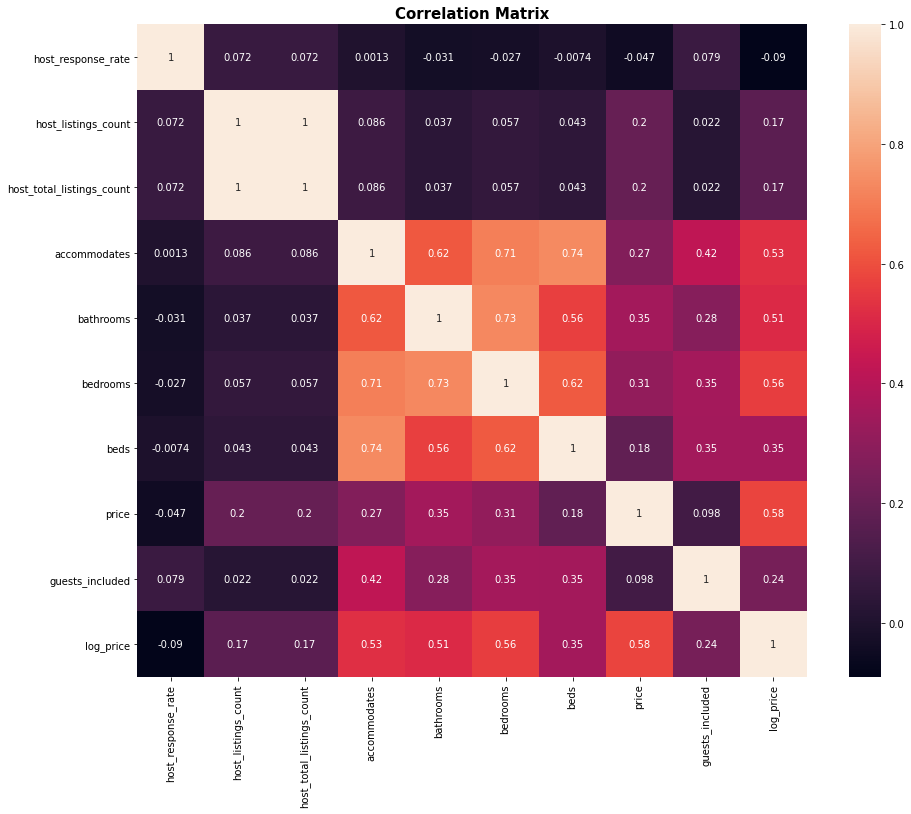

In [0]:
plt.figure(figsize=(15,12))
# Create a correlation matrix using the Pearson method
corr = airbnbdata.select(airbnbdata.columns).toPandas().corr(method="pearson")

# Create a heatmap using the correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Correlation Matrix",size=15, weight='bold')


The correlation table shows that there is no strong relationship between price and other features. This indicates no feature needed to be taken out of data. This relationship will be detailed with Residual Plots and Multicollinearity, but there is a stong corealtion between host_total_listings_count and host_listings_count, hence we can drop host_listings_count

In [0]:
airbnbmodel= airbnbdata.drop("host_listings_count")
#airbnb_model_x = airbnbmodel.select(*(F.col(airbnbmodel.columns[i]).alias(airbnbmodel.columns[i]) for i in range(len(airbnbmodel.columns)-1)))
#airbnb_model_y = airbnbmodel.select(F.col(airbnbmodel.columns[-1]).alias(airbnbmodel.columns[-1]))

# Print the DataFrames
#airbnb_model_x.show()
#airbnb_model_y.count()


Building the Model

In [0]:

airbnbmodel = airbnbmodel.na.drop()

In [0]:
airbnbmodel.dtypes

Out[77]: [('host_response_time', 'string'),
 ('host_response_rate', 'double'),
 ('host_is_superhost', 'string'),
 ('host_total_listings_count', 'double'),
 ('host_has_profile_pic', 'string'),
 ('host_identity_verified', 'string'),
 ('street', 'string'),
 ('neighbourhood', 'string'),
 ('neighbourhood_cleansed', 'string'),
 ('zipcode', 'string'),
 ('property_type', 'string'),
 ('room_type', 'string'),
 ('accommodates', 'double'),
 ('bathrooms', 'double'),
 ('bedrooms', 'double'),
 ('beds', 'double'),
 ('bed_type', 'string'),
 ('price', 'double'),
 ('guests_included', 'double'),
 ('log_price', 'double')]

Splitting string and double in to different coloumns

In [0]:
catCols=[x for (x, dataType) in airbnbmodel.dtypes if dataType=="string"]
numCols=[x for (x, dataType) in airbnbmodel.dtypes if ((dataType=="double")&(x != "price")&(x != "log_price"))]
print(airbnbmodel[numCols])

DataFrame[host_response_rate: double, host_total_listings_count: double, accommodates: double, bathrooms: double, bedrooms: double, beds: double, guests_included: double]


Implimenting VectorAssembler to bunch all the features together

In [0]:
coef_var=['host_response_rate','host_total_listings_count','accommodates','bathrooms','bedrooms','beds','guests_included']
vecort_assem=VectorAssembler(inputCols=numCols,outputCol="features")
output=vecort_assem.transform(airbnbmodel)
output.select("features").show(10, truncate=False)
output.count()
final_df=output.select('features','log_price')

+--------------------------------+
|features                        |
+--------------------------------+
|[100.0,2.0,5.0,1.0,2.0,2.0,2.0] |
|[100.0,3.0,3.0,1.0,1.0,2.0,2.0] |
|[100.0,1.0,3.0,1.0,1.0,2.0,2.0] |
|[100.0,1.0,3.0,1.5,1.0,2.0,2.0] |
|[100.0,1.0,2.0,1.0,1.0,2.0,2.0] |
|[97.0,7.0,13.0,7.0,6.0,7.0,7.0] |
|[100.0,1.0,1.0,1.0,1.0,1.0,1.0] |
|[100.0,7.0,11.0,3.5,4.0,6.0,8.0]|
|[100.0,53.0,3.5,1.0,1.5,2.0,2.0]|
|[97.0,7.0,6.0,3.0,3.0,3.5,4.0]  |
+--------------------------------+
only showing top 10 rows



Implimenting StandardScaler to get linear data

In [0]:
scaler =StandardScaler(inputCol='features', outputCol='scaled_feat',withStd=True,withMean=False)
scaled_model=scaler.fit(final_df)
cluster_df=scaled_model.transform(final_df)

In [0]:
cluster_df.show()

+--------------------+------------------+--------------------+
|            features|         log_price|         scaled_feat|
+--------------------+------------------+--------------------+
|[100.0,2.0,5.0,1....| 5.726847747587197|[3.72280659134008...|
|[100.0,3.0,3.0,1....|5.0689042022202315|[3.72280659134008...|
|[100.0,1.0,3.0,1....|  5.53338948872752|[3.72280659134008...|
|[100.0,1.0,3.0,1....| 5.857933154483459|[3.72280659134008...|
|[100.0,1.0,2.0,1....|5.3981627015177525|[3.72280659134008...|
|[97.0,7.0,13.0,7....| 8.129174996911793|[3.61112239359988...|
|[100.0,1.0,1.0,1....| 4.787491742782046|[3.72280659134008...|
|[100.0,7.0,11.0,3...| 6.320768294250582|[3.72280659134008...|
|[100.0,53.0,3.5,1...|5.1647859739235145|[3.72280659134008...|
|[97.0,7.0,6.0,3.0...| 6.782192056006791|[3.61112239359988...|
|[80.0,4.0,12.0,7....| 7.786967002614872|[2.97824527307206...|
|[100.0,2.1,2.0,1....| 4.969813299576001|[3.72280659134008...|
|[90.0,22.0,10.0,5...| 6.878326468291325|[3.35052593220

Splitting the Data by 70/30 in to train and test

In [0]:
#train_data, test_data = final_df.randomSplit([0.7,0.3])
train_data, test_data = cluster_df.randomSplit([0.7,0.3])

# Split the data into four subsets with sizes 20%, 40%, 60%, and 80%
train_data_split = train_data.randomSplit([0.2, 0.4, 0.6, 0.8])
    
train_data_split_0 =train_data_split[0]   
train_data_split_1 =train_data_split[1]   
train_data_split_2 =train_data_split[2]   
train_data_split_3 =train_data_split[3]   

test_data_split = test_data.randomSplit([0.2, 0.4, 0.6, 0.8])

test_data_split_0 =test_data_split[0]   
test_data_split_1 =test_data_split[1]   
test_data_split_2 =test_data_split[2]   
test_data_split_3 =test_data_split[3] 


Linear Regression Model for price prediction

In [0]:
#linear Regression
def linear_regression(train_data, test_data):
    startlr = time.perf_counter()
    lr = LinearRegression(featuresCol = 'scaled_feat', labelCol='log_price', maxIter=10, regParam=0.01, elasticNetParam=0.01) 
    lr_model = lr.fit(train_data)

    trainingSummary = lr_model.summary


    lr_predictions = lr_model.transform(test_data)
    #lr_predictions.select("prediction","log_price","scaled_feat").show(5)

    lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                     labelCol="log_price",metricName="rmse")
    #print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    #print("MAE: %f" % trainingSummary.meanAbsoluteError)
    rmseLinear=lr_evaluator.evaluate(lr_predictions)
    print("RMSE   on val data = %g" % rmseLinear)
   
    endlr = time.perf_counter()
    exectimelr=endlr - startlr 
    print(f"Execution time: {exectimelr} seconds")
    return (exectimelr, rmseLinear)

Random Forest Regression Model for price prediction

In [0]:
# random forest
def random_forestregressor(train_data, test_data):
    startrf = time.perf_counter()
    rf = RandomForestRegressor(featuresCol = 'scaled_feat', labelCol='log_price', 
                           maxDepth=13, 
                           minInstancesPerNode=1,
                           bootstrap=True
                          )
    rf_model = rf.fit(train_data)
    rf_predictions = rf_model.transform(test_data)
   # rf_predictions.select("prediction","log_price","scaled_feat").show(5)



    rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="rmse")
    rf_rmse=rf_evaluator.evaluate(rf_predictions)
    print("RMSE Squared (R2) on val data = %g" % rf_rmse)
    endrf=time.perf_counter()
    exectimerf=endrf - startrf 
    print(f"Execution time: {exectimerf} seconds")
    return (exectimerf, rf_rmse)

Decision Tree Regression Model for price prediction

In [0]:
# Create a Decision Tree Regressor
def decisiontree_regressor(train_data, test_data):
    startdt = time.perf_counter()
    dt_regressor = DecisionTreeRegressor(featuresCol="scaled_feat", labelCol="log_price", maxDepth=15)

    # Fit the model on the training data
    dt_regressor_model = dt_regressor.fit(train_data)

    # Make predictions on the test data
    dt_regressor_predictions = dt_regressor_model.transform(test_data)
    #dt_regressor_predictions.select("prediction","log_price","scaled_feat").show(5)
    # Evaluate the model's performance on the test data
    dt_regressor_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="log_price", metricName="rmse")
    rmse_dt = dt_regressor_evaluator.evaluate(dt_regressor_predictions)
    print("rmse:", rmse_dt)
    enddt=time.perf_counter()
    exectimedt=enddt - startdt
    return (exectimedt, rmse_dt)

Regression with XGBoost for price prediction

In [0]:
#xgboost
def xgboost_regressor(train_data, test_data):
    startxgb = time.perf_counter()
    xgb_regressor = SparkXGBRegressor(num_workers=3, label_col="log_price",  features_col="scaled_feat", max_depth=15)
    xgb_regressor_model = xgb_regressor.fit(train_data)
    xgb_predictions  = xgb_regressor_model.transform(test_data)
    #xgb_predictions.select("prediction","log_price","scaled_feat").show(5)
    xgb_evaluator = RegressionEvaluator(predictionCol="prediction", \
                     labelCol="log_price",metricName="rmse")
    rmse_xgb= xgb_evaluator.evaluate(xgb_predictions)
    
    # Evaluate the model on the test data
    print("RMSE on test data = %g" % rmse_xgb)
    endxgb=time.perf_counter()
    exectimexgb=endxgb-startxgb
    return (exectimexgb, rmse_xgb)

In [0]:
# 20% data
result =[]
lrexetime_2, lrrmse_2= linear_regression(train_data_split_0,test_data_split_0)
result.append({ "execution_time": lrexetime_2, "rmse": lrrmse_2, "Model": "lr", "data": 0.2 })
rfexetime_2, rfrmse_2=random_forestregressor(train_data_split_0,test_data_split_0)
result.append({ "execution_time": rfexetime_2, "rmse": rfrmse_2, "Model": "rf", "data": 0.2 })
dtexetime_2, dtrmse_2=decisiontree_regressor(train_data_split_0,test_data_split_0)
result.append({ "execution_time": dtexetime_2, "rmse": dtrmse_2, "Model": "dt", "data": 0.2 })
xgbexetime_2, xgbrmse_2=xgboost_regressor(train_data_split_0,test_data_split_0)
result.append({ "execution_time": xgbexetime_2, "rmse": xgbrmse_2, "Model": "xgb", "data": 0.2 })



RMSE   on val data = 0.717157
Execution time: 45.9946217859997 seconds
RMSE Squared (R2) on val data = 0.63351
Execution time: 162.88139412999953 seconds
rmse: 0.6866915729122295
/databricks/python/lib/python3.8/site-packages/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")
RMSE on test data = 0.655079


In [0]:
# 40% data
lrexetime_4, lrrmse_4= linear_regression(train_data_split_1,test_data_split_1)
result.append({ "execution_time": lrexetime_4, "rmse": lrrmse_4, "Model": "lr", "data": 0.4 })

rfexetime_4, rfrmse_4=random_forestregressor(train_data_split_1,test_data_split_1)
result.append({ "execution_time": rfexetime_4, "rmse": rfrmse_4, "Model": "rf", "data": 0.4 })

dtexetime_4, dtrmse_4=decisiontree_regressor(train_data_split_1,test_data_split_1)
result.append({ "execution_time": dtexetime_4, "rmse": dtrmse_4, "Model": "dt", "data": 0.4 })

xgbexetime_4, xgbrmse_4=xgboost_regressor(train_data_split_1,test_data_split_1)
result.append({ "execution_time": xgbexetime_4, "rmse": xgbrmse_4, "Model": "xgb", "data": 0.4 })

RMSE   on val data = 0.710861
Execution time: 48.25720841800012 seconds
RMSE Squared (R2) on val data = 0.608368
Execution time: 188.03718785799992 seconds
rmse: 0.6472173560929352
RMSE on test data = 0.613885


In [0]:
# 60% data

lrexetime_6, lrrmse_6 =linear_regression(train_data_split_2,test_data_split_2)
result.append({ "execution_time": lrexetime_6, "rmse": lrrmse_6, "Model": "lr", "data": 0.6 })

rfexetime_6, rfrmse_6=random_forestregressor(train_data_split_2,test_data_split_2)
result.append({ "execution_time": rfexetime_6, "rmse": rfrmse_6, "Model": "rf", "data": 0.6 })

dtexetime_6, dtrmse_6=decisiontree_regressor(train_data_split_2,test_data_split_2)
result.append({ "execution_time": dtexetime_6, "rmse": dtrmse_6, "Model": "dt", "data": 0.6 })

xgbexetime_6, xgbrmse_6 = xgboost_regressor(train_data_split_2,test_data_split_2)
result.append({ "execution_time": xgbexetime_6, "rmse": xgbrmse_6, "Model": "xgb", "data": 0.6 })

RMSE   on val data = 0.719165
Execution time: 48.7126700029994 seconds
RMSE Squared (R2) on val data = 0.607846
Execution time: 196.8214903119997 seconds
rmse: 0.6263511527988714
RMSE on test data = 0.597326


In [0]:
# 80% data
lrexetime_8, lrrmse_8 =linear_regression(train_data_split_3,test_data_split_3)
result.append({ "execution_time": lrexetime_8, "rmse": lrrmse_8, "Model": "lr", "data": 0.8 })

rfexetime_8, rfrmse_8=random_forestregressor(train_data_split_3,test_data_split_3)
result.append({ "execution_time": rfexetime_8, "rmse": rfrmse_8, "Model": "rf", "data": 0.8 })

dtexetime_8, dtrmse_8=decisiontree_regressor(train_data_split_3,test_data_split_3)
result.append({ "execution_time": dtexetime_8, "rmse": dtrmse_8, "Model": "dt", "data": 0.8 })

xgbexetime_8, xgbrmse_8 = xgboost_regressor(train_data_split_3,test_data_split_3)
result.append({ "execution_time": xgbexetime_8, "rmse": xgbrmse_8, "Model": "xgb", "data": 0.8 })

RMSE   on val data = 0.723175
Execution time: 55.20887699099967 seconds
RMSE Squared (R2) on val data = 0.607134
Execution time: 208.0364955620007 seconds
rmse: 0.6228975417099102
RMSE on test data = 0.587384


In [0]:
# 100% data
lrexetime, lrrmse =linear_regression(train_data,test_data)
result.append({ "execution_time": lrexetime, "rmse": lrrmse, "Model": "lr", "data": 1.0 })

rfexetime, rfrmse=random_forestregressor(train_data,test_data)
result.append({ "execution_time": rfexetime, "rmse": rfrmse, "Model": "rf", "data": 1.0 })

dtexetime, dtrmse=decisiontree_regressor(train_data,test_data)
result.append({ "execution_time": dtexetime, "rmse": dtrmse, "Model": "dt", "data": 1.0 })

xgbexetime, xgbrmse = xgboost_regressor(train_data,test_data)
result.append({ "execution_time": xgbexetime, "rmse": xgbrmse, "Model": "xgb", "data": 1.0 })

RMSE   on val data = 0.718746
Execution time: 48.410346192999896 seconds
RMSE Squared (R2) on val data = 0.597368
Execution time: 237.8467076220004 seconds
rmse: 0.5962893539529648
RMSE on test data = 0.547335


In [0]:
resultstab = spark.createDataFrame(result)

In [0]:
resultstab.show()
resultstab.write.mode('overwrite').format("csv").save("dbfs:/FileStore/tables/data/resultsdb.csv")

+-----+----+------------------+------------------+
|Model|data|    execution_time|              rmse|
+-----+----+------------------+------------------+
|   lr| 0.2|  45.9946217859997|0.7171565035455315|
|   rf| 0.2|162.88139412999953|0.6335103019852709|
|   dt| 0.2| 88.27906782800073|0.6866915729122295|
|  xgb| 0.2| 68.88163527899997|0.6550790964151072|
|   lr| 0.4| 48.25720841800012|0.7108608051004047|
|   rf| 0.4|188.03718785799992|0.6083680312632563|
|   dt| 0.4| 92.04064442900017|0.6472173560929352|
|  xgb| 0.4| 72.86114635800004|0.6138853650250492|
|   lr| 0.6|  48.7126700029994|0.7191649945283201|
|   rf| 0.6| 196.8214903119997|0.6078462695597355|
|   dt| 0.6| 93.93178378100038|0.6263511527988714|
|  xgb| 0.6| 86.98261941000055|0.5973258910978044|
|   lr| 0.8| 55.20887699099967|0.7231749578082584|
|   rf| 0.8| 208.0364955620007|0.6071341716766953|
|   dt| 0.8| 97.22412273000009|0.6228975417099102|
|  xgb| 0.8| 89.16838631100018| 0.587384116064587|
|   lr| 1.0|48.410346192999896|